# Why augmentation?
Simply according to the [paper](https://arxiv.org/abs/1711.08324), Data augmentation is used to alleviate the over-fitting problem.

Also, we should use 3d patches (sub-images) instead of the whole image. This is because: "[it] is infeasible for our 3D CNN [to use the entire image as input to the models] due to the GPU memory constraint. When the resolution of lung scans is kept at a fine level, even a single sample consumes more than the maximum memory of mainstream GPUs."
These patches are sized 128\*128\*128 for height, length, and width respectively.
At their paper, they have said that:

`Two kinds of patches are randomly selected. First, 70% of the inputs are selected so that they contain at least one nodule. Second, 30% of the inputs are cropped randomly from lung scans and may not contain any nodules.`

And I have covered this at `prepare/run` file of this repository. The code is quite easy.

Anyway, I want to describe `Resize`, `Random Cropping`, and `Rotation` which are mentioned in the paper. Actually, they have not coded the `Rotation` part and just flip the image, but I thought it would be great for the augmentation part if I cover it.

# Resize


In [1]:
from PIL import Image
from glob import glob
import pandas as pd
import skimage, os
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.measure import label,regionprops, perimeter
from skimage.morphology import binary_dilation, binary_opening, convex_hull_image
from skimage.filters import roberts, sobel
from skimage import measure, feature
from skimage.segmentation import clear_border
from skimage import data
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import pydicom
import scipy.misc
import numpy as np
import SimpleITK as sitk

In [2]:
def scale(img: np.array, scale_factor: float, spacing: tuple, centers: list, radii: list):
    # original values is between 0.8 and 1.15
    assert (.75 <= scale_factor <= 1.25)
    out_centers = [tuple(np.rint(np.array(c) * scale_factor).astype(int)) for c in centers]
    out_radii = [r * scale_factor for r in radii]
    spacing = np.array(spacing) * scale_factor
    img1 = scipy.ndimage.interpolation.zoom(img, spacing, mode='nearest')
    return img1, tuple(spacing), out_centers, out_radii

To test the functionality of this method, we need an argmax for 3d array. But there is no such method, so we write something like this to overcome the problem:

In [3]:
def argmax_3d(img: np.array):
    max1 = np.max(img, axis=0)
    argmax1 = np.argmax(img, axis=0)
    max2 = np.max(max1, axis=0)
    argmax2 = np.argmax(max1, axis=0)
    argmax3 = np.argmax(max2, axis=0)
    argmax_3d = (argmax1[argmax2[argmax3], argmax3], argmax2[argmax3], argmax3)
    return argmax_3d, img[argmax_3d]


All of these methods which I implemented, work for both 2d and 3d images. So first I show you the 2d one, then we will work on the 3d image.

First, Let's create a black and white image.

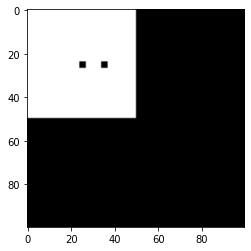

In [4]:
black_white = np.zeros((100,100))
centers = [(25,25), (25,35)]
for i in range(50):
    black_white[i, 0:50] = np.ones(50)

# creating fake nodule
for center in centers:
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            black_white[center[0] + i, center[1] + j] = 0.
from matplotlib import pyplot as plt
plt.imshow(black_white, cmap=plt.cm.gray)
plt.show()

Then we resize it:

shape (78, 78)
(0.7755605556043104, 0.7755605556043104) [0.7755605556043104, 1.5511211112086207]


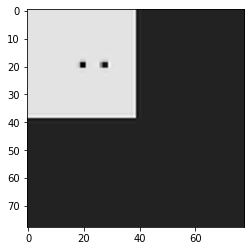

In [5]:
radii = [1,2] # radius of our toy nodule, but here we do not need it.
spacing = (1.,1.) # spacing of 3d array
rnd = np.random.random() / 2 + 0.75
bw2, bws2, bwc2, bwr2 = scale(img=black_white, scale_factor=rnd, spacing=spacing, centers=centers, radii=radii)
print('shape', bw2.shape)
print(bws2, bwr2)
plt.imshow(bw2, cmap=plt.cm.gray)
plt.show()

Now, to show you the 3d example, I want to make an all zeros 3d image with just one 1.0 in it. This is a toy example, in contrast to the real problem, the voxel in which its value is 1.0 will point to the center of a "possible nodule". We made the array to track the place of our "toy nodule" after transformations!

In [6]:
img = np.zeros((100, 100, 100), dtype=float)
centers = [(60, 60, 60)] # voxel which will be 1.0
img[centers[0]] = 1.
radii = [5] # radius of our toy nodule, but here we do not need it.
spacing = (1.,1.,1.) # spacing of 3d array
rnd = np.random.random() / 2 + 0.75
img2, spacing2, centers2, radii2 = scale(img=img, scale_factor=rnd, spacing=spacing, centers=centers, radii=radii)
print(spacing2, radii)

(0.8449698472452225, 0.8449698472452225, 0.8449698472452225) [5]


So now we wonder if the resulting center is still the highest value of the resulting image or not. Let's see:

In [7]:
print(centers2)
print(argmax_3d(img2))

[(51, 51, 51)]
((50, 50, 50), 0.4557698533434679)


Yes! It is. but as you see, the max value is less than 1.0! why? It is because of the `scipy.ndimage.interpolation.zoom` method which we have chosen mode='nearest'. You can find documentation [here](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.ndimage.interpolation.zoom.html).

# Random crop

Random cropping is very important to avoid over-fitting. We must consider not cropping in a manner that nodule always stays in the center of 3d image, so this is why it is called "random" cropping.

If we assume block_size as a constant, then we can assign each point inside of the original image exactly one cropping 3d cube.
Then the procedure is simple, first, we should define a bounding box for the center of cropping 3d cube, then randomly choose one of the points inside that bounding box as a center, and then crop 3d image!

Assume that the below picture is a ct scan which contains a nodule in it we want to randomly crop the image in a way that it contains nodule.
![not cropped image](./figs/one_3d_cube.jpeg)




One of the cropping forms could be this one:
![cropped image](./figs/two_3d_cubes.jpeg)

In [8]:
def _get_cube_from_img_new(img, origin: tuple, block_size=128, pad_value=106.):
    assert 2 <= len(origin) <= 3
    final_image_shape = tuple([block_size] * len(origin))
    result = np.ones(final_image_shape) * pad_value
    start_at_original_images = []
    end_at_original_images = []
    start_at_result_images = []
    end_at_result_images = []
    for i, center_of_a_dim in enumerate(origin):
        start_at_original_image = int(center_of_a_dim - block_size / 2)
        end_at_original_image = start_at_original_image + block_size
        if start_at_original_image < 0:
            start_at_result_image = abs(start_at_original_image)
            start_at_original_image = 0
        else:
            start_at_result_image = 0
        if end_at_original_image > img.shape[i]:
            end_at_original_image = img.shape[i]
            end_at_result_image = start_at_result_image + (end_at_original_image - start_at_original_image)
        else:
            end_at_result_image = block_size
        start_at_original_images.append(start_at_original_image)
        end_at_original_images.append(end_at_original_image)
        start_at_result_images.append(start_at_result_image)
        end_at_result_images.append(end_at_result_image)
    # for simplicity
    sri = start_at_result_images
    eri = end_at_result_images
    soi = start_at_original_images
    eoi = end_at_original_images
    if len(origin) == 3:
        result[sri[0]:eri[0], sri[1]:eri[1], sri[2]:eri[2]] = img[soi[0]:eoi[0], soi[1]:eoi[1], soi[2]:eoi[2]]
    elif len(origin) == 2:
        result[sri[0]:eri[0], sri[1]:eri[1]] = img[soi[0]:eoi[0], soi[1]:eoi[1]]
    return result

def random_crop(img: np.array, centers: list, radii: list, main_nodule_idx: int, spacing: tuple, block_size: int,
                pad_value: float, margin: int):
    max_radius_index = np.max(np.round(radii[main_nodule_idx] / np.array(spacing)).astype(int))
    center_of_cube = list(centers[main_nodule_idx])
    shifts = []
    for i in range(len(centers[main_nodule_idx])):
        high = int(block_size / 2) - max_radius_index - margin
        if high < 0:
            raise ValueError('Image can not be cropped with this margin! (decrease it)')
        shift = np.random.randint(low=-abs(high), high=abs(high))
        center_of_cube[i] += shift
        shifts.append(shift)    
    out_img = _get_cube_from_img_new(img, origin=tuple(center_of_cube), block_size=block_size, pad_value=pad_value)
    out_centers = []
    for i in range(len(centers)):
        diff = np.array(centers[main_nodule_idx]) - np.array(centers[i])
        out_centers.append(
            tuple(np.array([int(block_size / 2)] * len(centers[i]), dtype=int) - np.array(shifts, dtype=int) - diff))
    return out_img, out_centers


Like what we did previously, let's create a black and white image again.

original image:


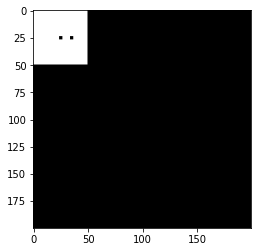

cropped image:
new nodule centers: [(54, 49), (54, 59)]


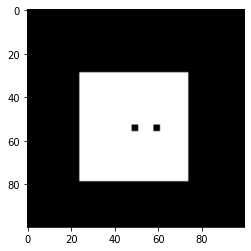

In [9]:
black_white = np.zeros((200,200))
centers = [(25,25), (25,35)]
for i in range(50):
    black_white[i, 0:50] = np.ones(50)

# creating fake nodule
for center in centers:
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            black_white[center[0] + i, center[1] + j] = 0.
print('original image:')
plt.imshow(black_white, cmap=plt.cm.gray)
plt.show()
out_img, out_centers = random_crop(black_white, centers=centers, radii=[1.,2.], main_nodule_idx=0, spacing=(1.,1.), block_size=100, pad_value=0, margin=10)
print('cropped image:')
print('new nodule centers:', out_centers)
plt.imshow(out_img, cmap=plt.cm.gray)
plt.show()

Now just like previous step, we want to test if it works for 3d image?

new parameters are: main_nodule_idx, pad_value, block_size, margin

* **main_nodule_idx**: we are passing all existing nodules at ct scan by `centers` and `radii` parameter. `centers` is a list which points to the center of nodules and `radii` is the list of radiuses for corresponding centers. With main_nodule_idx we specify which nodule MUST be inside the patch (also some others "may" be inside it). main_nodule_idx is an integer and is the index of the main nodule in the `radii` and `centers` list.
* **pad_value**: if a patch falls out of the original image, it will be filled with pad_value.
* **block_size**: size of the patch in each axis. (at the paper which we are going through it, block_size is 128 which means resulting patches are 128\*128\*128)
* **margin**: it is the margin that we don't want a nodule to be inside that area. if we set big a margin, it means that we want patches that their main nodule is near the center of the patch.

In [10]:
img = np.zeros((100, 100, 100), dtype=float)
centers = [(60, 60, 60)] # voxel which will be 1.0
img[centers[0]] = 1.
radii = [5] # radius of our toy nodule, but here we do not need it.
spacing = (1.,1.,1.) # spacing of 3d array
rnd = np.random.random() / 2 + 0.75
img3, centers3 = random_crop(img=img, centers=centers, radii=radii, main_nodule_idx=0, spacing=spacing, block_size=30, pad_value=0.0, margin=5)

In [11]:
print(argmax_3d(img3))
print(centers3[0])

((12, 11, 19), 1.0)
(12, 11, 19)


Yes!

Now I want to add another center to the original image. Lets test two scenarios:
* The second center is inside the cropped image
* The second center is NOT inside the cropped image

### The second center is inside the cropped image

I add the center of the next nodule with (56,56,56) which its distance to the first one is (4,4,4). so if I set the margin 5, it means that the second nodule will always be inside the marginal distance to the first nodule (because (4,4,4) < (5,5,5)), so random cropping will never cut out the second nodule and will always exist on the resulting patch.

In [12]:
img = np.zeros((100, 100, 100), dtype=float)
centers = [(60, 60, 60), (56,56,56)]
# stands for radiuses of nodules, but here we do not need it.
radii = [1, 2]
spacing = (1.,1.,1.)
img[centers[0]] = 1.
img[centers[1]] = 1.
img3, centers3 = random_crop(img=img, centers=centers, radii=radii, main_nodule_idx=0, spacing=spacing, block_size=30, pad_value=0.0,margin=5)
print(centers3)
print([img3[centers3[0]], img3[centers3[1]]])

[(24, 20, 13), (20, 16, 9)]
[1.0, 1.0]


### The second center is NOT inside the cropped image
Now I added second nodules center with a distance of (31,31,31) which is bigger than block_size! Meaning that it will always fall out of the resulting patch!

In [13]:
img = np.zeros((100, 100, 100), dtype=float)
centers = [(60, 60, 60), (91,91,91)]
# stands for radiuses of nodules, but here we do not need it.
radii = [5, 6]
spacing = (1.,1.,1.)
img[centers[0]] = 1.
img[centers[1]] = 1.
img3, centers3 = random_crop(img=img, centers=centers, radii=radii, main_nodule_idx=0, spacing=spacing, block_size=30, pad_value=0.0,margin=1)
print(centers3)
print([img3[centers3[0]], img3[centers3[1]]])

[(15, 17, 9), (46, 48, 40)]


IndexError: index 46 is out of bounds for axis 0 with size 30

As you can see, the second nodule is not inside of the cropped 3d patch. <b>because we had mentioned that `main_nodule_idx=0`</b>, we could change it to 1, then the first nodule would not be in the patch! 

# Random rotation

Now, we have some patches with the size of (block_size\*block_size\*block_size), we can randomly rotate it. But we should consider that if we rotate the 3d patch, `centers` of the nodules, as well as `spacing` of 3d array, may be affected.
(It is obvious that why centers change, but why spacing changes? because if we rotate a 3d array, then the resulting array's sort of axes may not be the same as the original one. for example, if we rotate a 3d array with axes sort of z,y,x 90 degrees, it may change the axes sort to y,z,x. so the spacing of z may not be the same as the spacing for y and we should change the spacing orders too!)

**note1:** All of our rotations are 90 degrees.

**note2:** Again! I have written the rotation method for both 2d and 3d usages. Here I show 2d version, But the 3d one works very similarly. (Try it!)

new parameter: rot_id
* rot_id: it is sth that I assigned to each rotation. for example in 2d, rot_id=3 means 3 * 90 degrees of rotation. if rot_id >= 4, it will flip with respect to y-axis.

In [14]:
from functools import partial

def _get_point_after_2d_rotation(in_points: list, shape: tuple, rot90s: int, flip: bool = False):
    assert len(in_points[0]) == 2 and len(shape) == 2
    rot90s = rot90s % 4
    result_points = []
    for in_point in in_points:
        result_point = list(in_point)
        for i in range(rot90s):
            previous = result_point.copy()
            axes = [0, 1]
            point_complement = (shape[0] - previous[0], shape[1] - previous[1])
            result_point[axes[0]] = point_complement[axes[1]]
            result_point[axes[1]] = previous[axes[0]]
        if flip:
            result_point[0] = shape[0] - result_point[0]
        result_points.append(tuple(result_point))
    return result_points


def _get_point_after_3d_rotation(in_points: list, shape: tuple, axes, rot90s: int, flip: bool = False):
    rot90s = rot90s % 4
    result_points = []
    for in_point in in_points:
        result_point = list(in_point)
        other_axis = [item for item in [0, 1, 2] if item not in axes]
        for i in range(rot90s):
            previous = result_point.copy()
            point_complement = np.array(shape, dtype=int) - np.array(previous, dtype=int)
            result_point[axes[0]] = point_complement[axes[1]]
            result_point[axes[1]] = previous[axes[0]]
        if flip:
            result_point[other_axis[0]] = shape[other_axis[0]] - result_point[other_axis[0]]
        result_points.append(tuple(result_point))
    return result_points


def rotate(img: np.array, spacing: tuple, centers: list, rotate_id: int):
    spacing = list(spacing)
    dimensions = len(img.shape)
    assert (dimensions == 3 and rotate_id < 24) or (dimensions == 2 and rotate_id < 8)
    other_axes = [i for i in range(dimensions)]

    if dimensions == 2:
        axis = [0]
        out_centers = partial(_get_point_after_2d_rotation, in_points=centers, shape=tuple(img.shape))
    else:  # dimensions == 3
        axis = rotate_id // 8
        other_axes.pop(axis)
        out_centers = partial(_get_point_after_3d_rotation, in_points=centers, shape=tuple(img.shape), axes=other_axes)

    which_rotation = rotate_id % 8
    flip = which_rotation >= 4
    rotation_times = (which_rotation % 4)

    spacing_exchanged = (which_rotation % 2) != 0
    if spacing_exchanged:
        if dimensions == 3:
            tmp = spacing[other_axes[0]]
            spacing[other_axes[0]] = spacing[other_axes[1]]
            spacing[other_axes[1]] = tmp
        elif dimensions == 2:
            tmp = spacing[0]
            spacing[0] = spacing[1]
            spacing[1] = tmp
    img = np.rot90(img, k=rotation_times, axes=other_axes)
    if flip:
        img = np.flip(img, axis=axis)
    return img, tuple(spacing), out_centers(rot90s=rotation_times, flip=flip)



In [15]:
black_white = np.zeros((200,200))
centers = [(25,25), (25,35)]
for i in range(50):
    black_white[i, 0:50] = np.ones(50)

# creating fake nodule
for center in centers:
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            black_white[center[0] + i, center[1] + j] = 0.

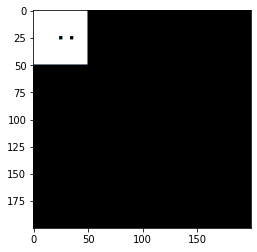

In [16]:
from matplotlib import pyplot as plt
plt.imshow(black_white, cmap=plt.cm.bone)
plt.show()

(1.0, 2.0) [(25, 25), (25, 35)]


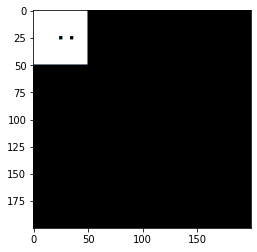

(2.0, 1.0) [(175, 25), (165, 25)]


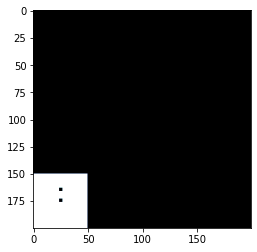

(1.0, 2.0) [(175, 175), (175, 165)]


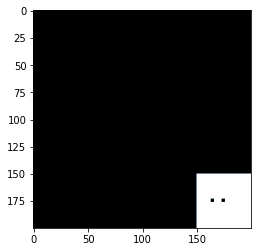

(2.0, 1.0) [(25, 175), (35, 175)]


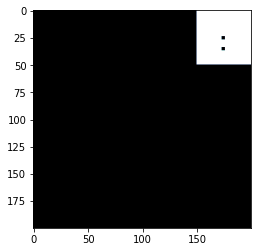

(1.0, 2.0) [(175, 25), (175, 35)]


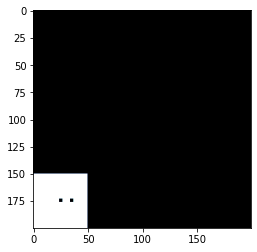

(2.0, 1.0) [(25, 25), (35, 25)]


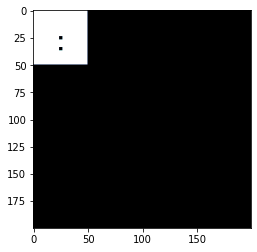

(1.0, 2.0) [(25, 175), (25, 165)]


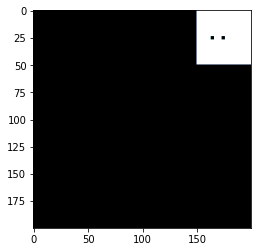

(2.0, 1.0) [(175, 175), (165, 175)]


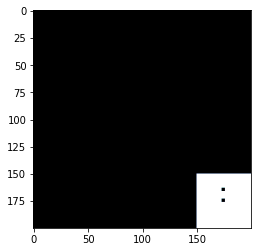

In [17]:
# i set spacing to be some dummy
spacing=(1.0,2.0)
for i in range(8):
    res_img, res_spacing, res_centers = rotate(black_white, spacing=spacing, centers=centers, rotate_id=i)
    print(res_spacing, res_centers)
    plt.imshow(res_img, cmap=plt.cm.bone)
    plt.show()


As you can see, all possible rotations have been made!

# Finally!
Putting these 3 transforms, we have a great augmentation tool!

In [18]:
def get_augmented_cube(img: np.array, radii: list, centers: list, main_nodule_idx: int, spacing: tuple, block_size=128,
                       pad_value=106, margin=10, rot_id=None):
    scale_factor = np.random.random() / 2 + .75
    rotate_id = np.random.randint(0, 24) if not rot_id else rot_id
    img1, spacing1, centers1, radii1 = scale(img, scale_factor=scale_factor, spacing=spacing, centers=centers,
                                             radii=radii)
    img2, centers2 = random_crop(img=img1, centers=centers1, radii=radii1, main_nodule_idx=main_nodule_idx,
                                 spacing=spacing1, block_size=block_size, pad_value=pad_value, margin=margin)
    
    existing_centers_in_patch = []
    for i in range(len(centers2)):
        dont_count = False
        for ax in centers2[i]:
            if not (0 <= ax <= block_size):
                dont_count = True
                break
        if not dont_count:
            existing_centers_in_patch.append(i)
    img3, spacing2, centers3 = rotate(img=img2, spacing=spacing1, centers=centers2, rotate_id=rotate_id)
    return img3, radii1, centers3, spacing2, existing_centers_in_patch


In [19]:
black_white = np.zeros((200,200))
centers = [(25,25), (25,35)]
for i in range(50):
    black_white[i, 0:50] = np.ones(50)

# creating fake nodule
for center in centers:
    for i in [-1,0,1]:
        for j in [-1,0,1]:
            black_white[center[0] + i, center[1] + j] = 0.
black_white2, radii2, centers2, spacing2, existing_centers_in_patch = get_augmented_cube(black_white, radii=[1.,1.], centers=centers, main_nodule_idx=0, spacing=(1.,1.), block_size = 100, pad_value=0, margin = 10, rot_id=5)

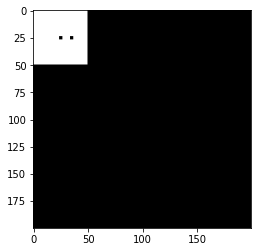

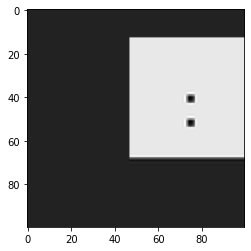

[(41, 75), (52, 75)]
Which nodules exist in the final patch: [0, 1]


In [20]:
from matplotlib import pyplot as plt
plt.imshow(black_white, cmap=plt.cm.gray)
plt.show()

plt.imshow(black_white2, cmap=plt.cm.gray)
plt.show()
print(centers2)
print('Which nodules exist in the final patch:', existing_centers_in_patch)

Tadaaa! This is our amazing result!:)


I emphasize once again that this process has been done with 2d image, But works for the 3d images of LUNA16 too! (It was trivial because our mission was to augment the LUNA16;) )

I showed you this procedure in 2d because the 3d image has got some difficulty in showing the results.

However, to see the results of 3d, first, you should download the LUNA16 dataset, I have described it in [this jupyter notebook](./Preprocessor.ipynb) (**Load image** part), then change 3 first variables of `configs.py` (it is in the root of this repository) to your own environment, run the `prepare/run`, then np.load(addr) which addr is the path to one of the .npy files at `OUTPUT_PATH/positives/` directory. (what is `OUTPUT_PATH`? you have modified it in `configs.py`!)